In [6]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold

import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from torch.func import stack_module_state
from torch.func import vmap

from lightning.fabric import Fabric

In [7]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [8]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 6
batch_size = 2
learning_rate = 0.001
dropout = 0.5
# dropout = 0.6990787087509548

In [9]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset.csv", offset=0, transform=transforms.ToTensor())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# # Without Validation Set
# trainset, testset = torch.utils.data.Subset(dataset, range(train_size)), torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=10)

# trainloader = fabric.setup_dataloaders(trainloader)

# With Validation Set
# Split dataset into training and test sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=False)

# Further split training set into training and validation sets
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, shuffle=False)  # 0.25 x 0.8 = 0.2

trainset = torch.utils.data.Subset(dataset, train_indices)
valset = torch.utils.data.Subset(dataset, val_indices)
testset = torch.utils.data.Subset(dataset, test_indices)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=10)

trainloader = fabric.setup_dataloaders(trainloader)
valloader = fabric.setup_dataloaders(valloader)


# # Get a batch of training data
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
# images = torch.stack(images)
# print(images.shape)
# print(labels.shape)

# print(images)
# print(labels)

In [10]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
            
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)
        
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, optimizer = fabric.setup(model, optimizer)
model.train()

_FabricModule(
  (_forward_module): GmiSwinTransformer(
    (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pretrained_model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_pa

In [11]:
torch.cuda.empty_cache()

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 1, Index: 0, Loss: 3.6201
Epoch: 1, Index: 1, Loss: 1.9780
Epoch: 1, Index: 2, Loss: 11.6430
Epoch: 1, Index: 3, Loss: 7.7627
Epoch: 1, Index: 4, Loss: 9.9936
Epoch: 1, Index: 5, Loss: 1.6049
Epoch: 1, Index: 6, Loss: 5.3139
Epoch: 1, Index: 7, Loss: 5.7453
Epoch: 1, Index: 8, Loss: 1.1946
Epoch: 1, Index: 9, Loss: 2.9290
Epoch: 1, Index: 10, Loss: 9.5897
Epoch: 1, Index: 11, Loss: 5.5413
Epoch: 1, Index: 12, Loss: 4.2239
Epoch: 1, Index: 13, Loss: 0.2243
Epoch: 1, Index: 14, Loss: 0.8248
Epoch: 1, Index: 15, Loss: 1.6998
Epoch: 1, Index: 16, Loss: 3.1109
Epoch: 1, Index: 17, Loss: 0.2454
Epoch: 1, Index: 18, Loss: 1.8695
Epoch: 1, Index: 19, Loss: 0.6759
Epoch: 1, Index: 20, Loss: 8.4574
Epoch: 1, Index: 21, Loss: 5.8507
Epoch: 1, Index: 22, Loss: 15.5633
Epoch: 1, Index: 23, Loss: 4.5908
Epoch: 1, Index: 24, Loss: 8.3185
Epoch: 1, Index: 25, Loss: 2.6803
Epoch: 1, Index: 26, Loss: 1.8733
Epoch: 1, Index: 27, Loss: 10.3435
Epoch: 1, Index: 28, Loss: 1.5250
Epoch: 1, Index: 29, 

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.20551970601081848
Validation Loss:  0.7423605918884277
Validation Loss:  0.19961345195770264
Validation Loss:  0.4985228478908539
Validation Loss:  0.7068996429443359
Validation Loss:  0.6702990531921387
Validation Loss:  0.7099562883377075
Validation Loss:  0.2559814453125
Validation Loss:  2.422592878341675
Validation Loss:  5.422276973724365
Validation Loss:  1.6767033338546753
Validation Loss:  0.874593198299408
Validation Loss:  0.7895148992538452
Validation Loss:  1.3262939453125
Validation Loss:  0.9419465065002441
Validation Loss:  2.9166259765625
Validation Loss:  0.05067124962806702
Validation Loss:  1.3317680358886719
Validation Loss:  0.733296275138855
Validation Loss:  1.08383047580719
Validation Loss:  0.9694143533706665
Validation Loss:  0.028331398963928223
Validation Loss:  0.31640625
Validation Loss:  1.9958713054656982
Validation Loss:  0.2364501953125
Validation Loss:  4.068477153778076
Validation Loss:  0.3671475946903229
Validation Loss:  0.467

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 2, Index: 0, Loss: 2.3766
Epoch: 2, Index: 1, Loss: 2.3481
Epoch: 2, Index: 2, Loss: 2.3281
Epoch: 2, Index: 3, Loss: 1.0469
Epoch: 2, Index: 4, Loss: 2.6375
Epoch: 2, Index: 5, Loss: 0.7094
Epoch: 2, Index: 6, Loss: 3.7408
Epoch: 2, Index: 7, Loss: 0.9888
Epoch: 2, Index: 8, Loss: 2.1763
Epoch: 2, Index: 9, Loss: 0.5110
Epoch: 2, Index: 10, Loss: 0.3658
Epoch: 2, Index: 11, Loss: 3.3685
Epoch: 2, Index: 12, Loss: 1.4346
Epoch: 2, Index: 13, Loss: 1.0495
Epoch: 2, Index: 14, Loss: 0.3588
Epoch: 2, Index: 15, Loss: 0.0610
Epoch: 2, Index: 16, Loss: 2.3936
Epoch: 2, Index: 17, Loss: 0.6972
Epoch: 2, Index: 18, Loss: 1.1499
Epoch: 2, Index: 19, Loss: 8.8047
Epoch: 2, Index: 20, Loss: 1.0754
Epoch: 2, Index: 21, Loss: 0.7404
Epoch: 2, Index: 22, Loss: 3.2094
Epoch: 2, Index: 23, Loss: 1.9129
Epoch: 2, Index: 24, Loss: 2.9317
Epoch: 2, Index: 25, Loss: 1.3472
Epoch: 2, Index: 26, Loss: 2.0228
Epoch: 2, Index: 27, Loss: 0.4498
Epoch: 2, Index: 28, Loss: 8.0069
Epoch: 2, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.10252480208873749
Validation Loss:  1.6015503406524658
Validation Loss:  0.34728559851646423
Validation Loss:  1.425593376159668
Validation Loss:  2.111880302429199
Validation Loss:  1.0046803951263428
Validation Loss:  1.1702300310134888
Validation Loss:  0.639678955078125
Validation Loss:  0.8910259008407593
Validation Loss:  6.132836818695068
Validation Loss:  2.1799633502960205
Validation Loss:  0.29770076274871826
Validation Loss:  0.03301813080906868
Validation Loss:  0.94342041015625
Validation Loss:  0.21241939067840576
Validation Loss:  5.3173828125
Validation Loss:  0.20658254623413086
Validation Loss:  1.7122076749801636
Validation Loss:  0.23892343044281006
Validation Loss:  1.1341722011566162
Validation Loss:  1.5889108180999756
Validation Loss:  0.45215195417404175
Validation Loss:  0.023223876953125
Validation Loss:  0.4824301302433014
Validation Loss:  0.56719970703125
Validation Loss:  5.975184917449951
Validation Loss:  1.7071155309677124
Validatio

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 3, Index: 0, Loss: 8.6770
Epoch: 3, Index: 1, Loss: 3.3286
Epoch: 3, Index: 2, Loss: 0.7497
Epoch: 3, Index: 3, Loss: 4.4034
Epoch: 3, Index: 4, Loss: 1.0106
Epoch: 3, Index: 5, Loss: 1.1270
Epoch: 3, Index: 6, Loss: 0.9582
Epoch: 3, Index: 7, Loss: 0.4562
Epoch: 3, Index: 8, Loss: 4.7189
Epoch: 3, Index: 9, Loss: 6.9088
Epoch: 3, Index: 10, Loss: 0.9806
Epoch: 3, Index: 11, Loss: 0.3489
Epoch: 3, Index: 12, Loss: 2.3733
Epoch: 3, Index: 13, Loss: 10.4624
Epoch: 3, Index: 14, Loss: 1.2643
Epoch: 3, Index: 15, Loss: 7.6213
Epoch: 3, Index: 16, Loss: 0.9640
Epoch: 3, Index: 17, Loss: 3.0353
Epoch: 3, Index: 18, Loss: 1.6373
Epoch: 3, Index: 19, Loss: 1.0154
Epoch: 3, Index: 20, Loss: 0.0886
Epoch: 3, Index: 21, Loss: 1.2053
Epoch: 3, Index: 22, Loss: 1.0904
Epoch: 3, Index: 23, Loss: 1.1838
Epoch: 3, Index: 24, Loss: 2.2810
Epoch: 3, Index: 25, Loss: 2.6447
Epoch: 3, Index: 26, Loss: 0.6604
Epoch: 3, Index: 27, Loss: 0.3193
Epoch: 3, Index: 28, Loss: 0.1166
Epoch: 3, Index: 29, Lo

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.06138027459383011
Validation Loss:  1.5432615280151367
Validation Loss:  0.3661838173866272
Validation Loss:  1.0731598138809204
Validation Loss:  1.687188744544983
Validation Loss:  0.8643081188201904
Validation Loss:  1.1641491651535034
Validation Loss:  0.57647705078125
Validation Loss:  1.0565366744995117
Validation Loss:  5.629168510437012
Validation Loss:  2.054971218109131
Validation Loss:  0.3179800808429718
Validation Loss:  0.057232968509197235
Validation Loss:  0.872833251953125
Validation Loss:  0.3258390724658966
Validation Loss:  4.7081298828125
Validation Loss:  0.1854800134897232
Validation Loss:  1.6927984952926636
Validation Loss:  0.22089534997940063
Validation Loss:  0.9897952079772949
Validation Loss:  1.5484586954116821
Validation Loss:  0.3907046914100647
Validation Loss:  0.020538330078125
Validation Loss:  0.5547418594360352
Validation Loss:  0.4166259765625
Validation Loss:  5.673770427703857
Validation Loss:  1.5742731094360352
Validation 

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 4, Index: 0, Loss: 2.6138
Epoch: 4, Index: 1, Loss: 0.4298
Epoch: 4, Index: 2, Loss: 0.8668
Epoch: 4, Index: 3, Loss: 0.8544
Epoch: 4, Index: 4, Loss: 0.2688
Epoch: 4, Index: 5, Loss: 0.9942
Epoch: 4, Index: 6, Loss: 0.8138
Epoch: 4, Index: 7, Loss: 1.6234
Epoch: 4, Index: 8, Loss: 1.7967
Epoch: 4, Index: 9, Loss: 1.4650
Epoch: 4, Index: 10, Loss: 1.2073
Epoch: 4, Index: 11, Loss: 1.0767
Epoch: 4, Index: 12, Loss: 0.1699
Epoch: 4, Index: 13, Loss: 0.8756
Epoch: 4, Index: 14, Loss: 2.8841
Epoch: 4, Index: 15, Loss: 1.0376
Epoch: 4, Index: 16, Loss: 0.9179
Epoch: 4, Index: 17, Loss: 1.5780
Epoch: 4, Index: 18, Loss: 0.0795
Epoch: 4, Index: 19, Loss: 0.2350
Epoch: 4, Index: 20, Loss: 5.6401
Epoch: 4, Index: 21, Loss: 0.8940
Epoch: 4, Index: 22, Loss: 0.5738
Epoch: 4, Index: 23, Loss: 1.9005
Epoch: 4, Index: 24, Loss: 2.0444
Epoch: 4, Index: 25, Loss: 5.2307
Epoch: 4, Index: 26, Loss: 0.4966
Epoch: 4, Index: 27, Loss: 0.0488
Epoch: 4, Index: 28, Loss: 1.2836
Epoch: 4, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.0003478217695374042
Validation Loss:  1.2190793752670288
Validation Loss:  0.2644064426422119
Validation Loss:  0.5807963013648987
Validation Loss:  1.1444172859191895
Validation Loss:  0.49577173590660095
Validation Loss:  0.8400226831436157
Validation Loss:  0.379150390625
Validation Loss:  1.667242407798767
Validation Loss:  5.687641143798828
Validation Loss:  1.3103976249694824
Validation Loss:  0.5011126399040222
Validation Loss:  0.16565164923667908
Validation Loss:  0.80908203125
Validation Loss:  0.8031672239303589
Validation Loss:  3.2178955078125
Validation Loss:  0.04546124488115311
Validation Loss:  1.7038776874542236
Validation Loss:  0.2695735991001129
Validation Loss:  0.7725139856338501
Validation Loss:  1.2570492029190063
Validation Loss:  0.10256478935480118
Validation Loss:  0.0103759765625
Validation Loss:  0.830538272857666
Validation Loss:  0.1749267578125
Validation Loss:  4.535840034484863
Validation Loss:  0.8612852692604065
Validation Loss:

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 5, Index: 0, Loss: 1.9065
Epoch: 5, Index: 1, Loss: 3.9741
Epoch: 5, Index: 2, Loss: 0.7181
Epoch: 5, Index: 3, Loss: 3.0728
Epoch: 5, Index: 4, Loss: 0.4710
Epoch: 5, Index: 5, Loss: 2.0964
Epoch: 5, Index: 6, Loss: 3.1430
Epoch: 5, Index: 7, Loss: 0.5353
Epoch: 5, Index: 8, Loss: 4.8492
Epoch: 5, Index: 9, Loss: 3.5631
Epoch: 5, Index: 10, Loss: 2.9709
Epoch: 5, Index: 11, Loss: 2.6837
Epoch: 5, Index: 12, Loss: 1.3098
Epoch: 5, Index: 13, Loss: 1.0016
Epoch: 5, Index: 14, Loss: 5.9822
Epoch: 5, Index: 15, Loss: 1.7565
Epoch: 5, Index: 16, Loss: 0.9159
Epoch: 5, Index: 17, Loss: 0.8706
Epoch: 5, Index: 18, Loss: 1.9575
Epoch: 5, Index: 19, Loss: 1.3118
Epoch: 5, Index: 20, Loss: 0.9081
Epoch: 5, Index: 21, Loss: 1.5950
Epoch: 5, Index: 22, Loss: 0.8800
Epoch: 5, Index: 23, Loss: 0.1723
Epoch: 5, Index: 24, Loss: 0.0159
Epoch: 5, Index: 25, Loss: 0.0898
Epoch: 5, Index: 26, Loss: 2.0330
Epoch: 5, Index: 27, Loss: 0.4289
Epoch: 5, Index: 28, Loss: 4.9348
Epoch: 5, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.05707754194736481
Validation Loss:  1.6295503377914429
Validation Loss:  0.3655734658241272
Validation Loss:  0.893999457359314
Validation Loss:  1.5995266437530518
Validation Loss:  0.6793725490570068
Validation Loss:  1.1689406633377075
Validation Loss:  0.612701416015625
Validation Loss:  1.0633342266082764
Validation Loss:  5.8615593910217285
Validation Loss:  1.7061173915863037
Validation Loss:  0.34989386796951294
Validation Loss:  0.04681915044784546
Validation Loss:  0.8941650390625
Validation Loss:  0.487522691488266
Validation Loss:  4.2354736328125
Validation Loss:  0.20658254623413086
Validation Loss:  1.8685575723648071
Validation Loss:  0.216294527053833
Validation Loss:  1.0176258087158203
Validation Loss:  1.5459486246109009
Validation Loss:  0.3135022819042206
Validation Loss:  0.0142822265625
Validation Loss:  0.524132490158081
Validation Loss:  0.452911376953125
Validation Loss:  5.529270648956299
Validation Loss:  1.5900501012802124
Validation Lo

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 6, Index: 0, Loss: 0.8568
Epoch: 6, Index: 1, Loss: 0.8081
Epoch: 6, Index: 2, Loss: 0.2514
Epoch: 6, Index: 3, Loss: 0.8478
Epoch: 6, Index: 4, Loss: 2.1262
Epoch: 6, Index: 5, Loss: 0.7002
Epoch: 6, Index: 6, Loss: 0.8325
Epoch: 6, Index: 7, Loss: 0.0665
Epoch: 6, Index: 8, Loss: 2.1095
Epoch: 6, Index: 9, Loss: 1.8474
Epoch: 6, Index: 10, Loss: 1.7754
Epoch: 6, Index: 11, Loss: 0.8281
Epoch: 6, Index: 12, Loss: 0.3974
Epoch: 6, Index: 13, Loss: 0.4001
Epoch: 6, Index: 14, Loss: 0.8081
Epoch: 6, Index: 15, Loss: 0.7264
Epoch: 6, Index: 16, Loss: 0.3715
Epoch: 6, Index: 17, Loss: 0.8406
Epoch: 6, Index: 18, Loss: 0.5776
Epoch: 6, Index: 19, Loss: 1.6357
Epoch: 6, Index: 20, Loss: 0.7796
Epoch: 6, Index: 21, Loss: 1.0563
Epoch: 6, Index: 22, Loss: 1.0383
Epoch: 6, Index: 23, Loss: 2.6401
Epoch: 6, Index: 24, Loss: 0.9822
Epoch: 6, Index: 25, Loss: 6.6056
Epoch: 6, Index: 26, Loss: 0.0168
Epoch: 6, Index: 27, Loss: 2.0862
Epoch: 6, Index: 28, Loss: 0.7899
Epoch: 6, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.016996268182992935
Validation Loss:  1.1618127822875977
Validation Loss:  0.27671992778778076
Validation Loss:  0.34155309200286865
Validation Loss:  1.4377769231796265
Validation Loss:  0.548733651638031
Validation Loss:  0.8727521896362305
Validation Loss:  0.2960205078125
Validation Loss:  1.927922010421753
Validation Loss:  5.956957817077637
Validation Loss:  1.2601525783538818
Validation Loss:  0.5534672141075134
Validation Loss:  0.3520500659942627
Validation Loss:  0.873291015625
Validation Loss:  0.5472589731216431
Validation Loss:  2.2359619140625
Validation Loss:  0.0154485572129488
Validation Loss:  1.5885893106460571
Validation Loss:  0.29610973596572876
Validation Loss:  0.9726321697235107
Validation Loss:  0.9253978133201599
Validation Loss:  0.06800326704978943
Validation Loss:  0.0517578125
Validation Loss:  1.1541173458099365
Validation Loss:  0.2548828125
Validation Loss:  4.042203903198242
Validation Loss:  0.7823985815048218
Validation Loss:  0.5

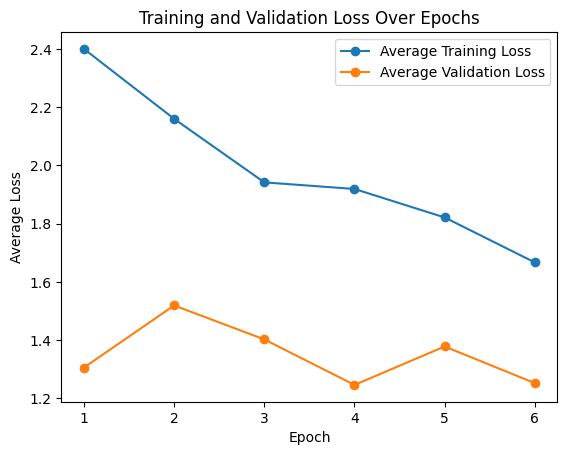

In [12]:
# Training the model
n_total_steps = len(trainloader)
avg_train_loss_over_epochs = []
avg_val_loss_over_epochs = []

for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    
    # Training loop
    model.train()
    for i, (images, labels) in tqdm(enumerate(trainloader), desc="Training Progress", total=len(trainloader)):
        # Move images and labels to device
        images = images.float()
        # images = images.permute(1, 0, 2, 3, 4)  # Change shape to [5, 10, 1, 224, 224]
        labels = labels.float()

        # Forward pass with autograd
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

        # Backward pass and optimization
        optimizer.zero_grad()
        fabric.backward(loss)
        optimizer.step()
        # Store the loss
        train_losses.append(loss.item())
    
    # Store the average training loss for this epoch
    avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc="Validation Progress"):
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)
            labels = labels.float()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            print("Validation Loss: ", loss.item())
            val_losses.append(loss.item())
    
    # Store the average validation loss for this epoch
    avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))

# Plot loss over epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [13]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Test the model
model.eval()
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=10)
testloader = fabric.setup_dataloaders(testloader)
test_losses = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing Progress"):
        images = images.float()
        # images = images.permute(1, 0, 2, 3, 4)
        labels = labels.float()
        print("Label: ", labels)
        outputs = model(images).squeeze(1)
        print("Output: ", outputs)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

avg_test_loss = sum(test_losses) / len(test_losses)
rmse = math.sqrt(avg_test_loss)
mse = mean_squared_error(all_labels, all_outputs)
mae = mean_absolute_error(all_labels, all_outputs)
r2 = r2_score(all_labels, all_outputs)

print(f'Average test loss: {avg_test_loss:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

Testing Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Label:  tensor([3.3330, 4.6670], device='cuda:0')
Output:  tensor([3.1406, 2.5781], device='cuda:0')
Label:  tensor([2.6670, 4.6670], device='cuda:0')
Output:  tensor([2.7031, 2.7031], device='cuda:0')
Label:  tensor([2.6670, 2.3330], device='cuda:0')
Output:  tensor([3.3750, 3.0156], device='cuda:0')
Label:  tensor([3.3330, 3.3330], device='cuda:0')
Output:  tensor([3.4062, 2.8125], device='cuda:0')
Label:  tensor([3.3330, 4.0000], device='cuda:0')
Output:  tensor([3.7500, 2.7344], device='cuda:0')
Label:  tensor([2.6670, 4.6670], device='cuda:0')
Output:  tensor([3.1406, 3.2812], device='cuda:0')
Label:  tensor([3.6670, 3.6670], device='cuda:0')
Output:  tensor([3.2500, 2.6875], device='cuda:0')
Label:  tensor([3.6670, 2.3330], device='cuda:0')
Output:  tensor([2.9688, 3.1562], device='cuda:0')
Label:  tensor([6., 3.], device='cuda:0')
Output:  tensor([3.1250, 3.3438], device='cuda:0')
Label:  tensor([3.0000, 2.3330], device='cuda:0')
Output:  tensor([2.8125, 3.1406], device='cuda:0'

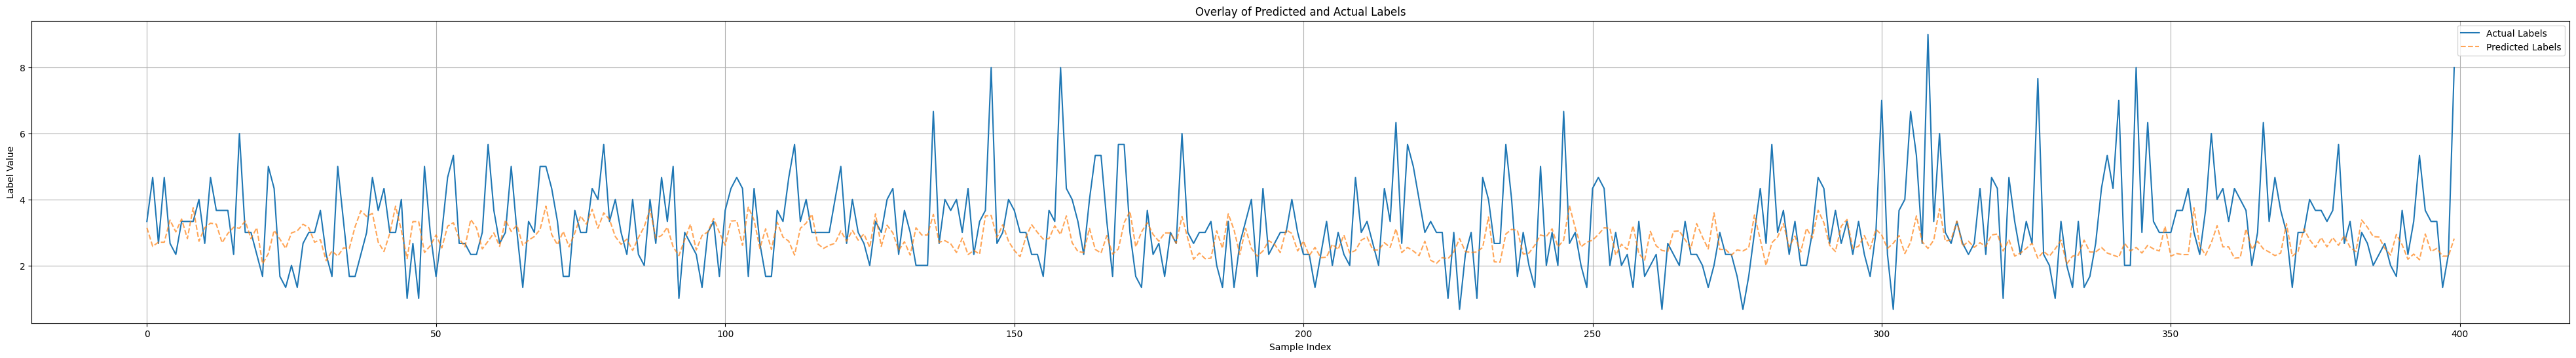

[3.140625, 2.578125, 2.703125, 2.703125, 3.375, 3.015625, 3.40625, 2.8125, 3.75, 2.734375, 3.140625, 3.28125, 3.25, 2.6875, 2.96875, 3.15625, 3.125, 3.34375, 2.8125, 3.140625, 2.046875, 2.359375, 3.0625, 2.796875, 2.515625, 2.984375, 3.046875, 3.25, 3.140625, 2.703125, 2.78125, 2.140625, 2.4375, 2.28125, 2.53125, 2.515625, 3.171875, 3.65625, 3.484375, 3.578125, 2.703125, 2.421875, 2.96875, 3.796875, 3.0625, 2.203125, 3.328125, 3.328125, 2.390625, 2.59375, 2.921875, 2.53125, 3.1875, 3.296875, 2.8125, 2.5625, 3.390625, 3.140625, 2.5, 2.734375, 2.984375, 2.578125, 3.375, 3.03125, 3.21875, 2.609375, 2.765625, 2.875, 3.09375, 3.796875, 2.9375, 2.625, 3.03125, 2.5625, 2.984375, 3.5, 3.25, 3.703125, 3.125, 3.59375, 3.390625, 2.875, 2.640625, 2.796875, 2.453125, 2.84375, 3.171875, 3.703125, 2.828125, 2.90625, 3.15625, 2.5625, 2.296875, 2.78125, 3.25, 2.46875, 2.90625, 3.015625, 3.421875, 3.0, 2.609375, 3.34375, 3.359375, 2.609375, 3.765625, 3.375, 2.515625, 3.109375, 2.484375, 3.3125, 2.859375

In [14]:
plt.figure(figsize=(50, 6))

plt.plot(all_labels, '-', label='Actual Labels')
plt.plot(all_outputs, '--', label='Predicted Labels', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.title('Overlay of Predicted and Actual Labels')
plt.legend()
plt.grid(True)
plt.show()
print(all_outputs)